# Отчет по Кейсу 1: Настройка простого пайплайна CI с использованием GitHub Actions


**Файл:** `.github/workflows/tests.yml`
**Цель:** Автоматическое тестирование проекта на Python при пуше в `main` и при Pull Request.

```yaml
name: Python tests 

on:
  push:
    branches: [ main ]
  pull_request:
    branches: [ main ]

jobs:
  test:
    runs-on: ubuntu-latest
    strategy:
      matrix:
        python-version: ["3.10", "3.11", "3.12"]

    steps:
      - name: Checkout repo
        uses: actions/checkout@v4

      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: ${{ matrix.python-version }}

      - name: Upgrade pip
        run: python -m pip install --upgrade pip

      - name: Install dependencies
        run: |
          if [ -f requirements.txt ]; then pip install -r requirements.txt; fi

      - name: Run unit tests
        run: python -m unittest discover -s tests -v
```

**Результат:** Настроена матрица для тестирования на Python 3.10, 3.11 и 3.12. Автотесты запускаются при пуше и PR.

---

### **2. Очистка проекта**

Удалены лишние директории `gg` в:

* `assets/gg`
* `src/gg`
* `tests/gg`

**Результат:** Структура проекта упрощена, все ненужные файлы удалены.

---

### **3. Основной код игры "Змейка"**

**Файл:** `src/game.py`

```python
import random
from dataclasses import dataclass, field
from typing import List, Tuple

Point = Tuple[int, int]

@dataclass
class SnakeModel:
    width: int = 20
    height: int = 15
    init_length: int = 3
    snake: List[Point] = field(default_factory=list)
    direction: Point = (1, 0)
    food: Point = None
    alive: bool = True

    def __post_init__(self):
        mid_y = self.height // 2
        mid_x = self.width // 2
        self.snake = [(mid_x - i, mid_y) for i in range(self.init_length)]
        self.place_food()

    def place_food(self):
        empty = [(x, y) for x in range(self.width) for y in range(self.height) if (x, y) not in self.snake]
        self.food = random.choice(empty) if empty else None

    def set_direction(self, dx: int, dy: int):
        if (dx, dy) != (-self.direction[0], -self.direction[1]):
            self.direction = (dx, dy)

    def step(self):
        if not self.alive:
            return
        head = self.snake[0]
        new_head = (head[0] + self.direction[0], head[1] + self.direction[1])
        if not (0 <= new_head[0] < self.width and 0 <= new_head[1] < self.height):
            self.alive = False
            return
        if new_head in self.snake:
            self.alive = False
            return
        self.snake.insert(0, new_head)
        if self.food == new_head:
            self.place_food()
        else:
            self.snake.pop()

    def get_state(self):
        return {
            'snake': list(self.snake),
            'food': self.food,
            'alive': self.alive,
            'direction': self.direction,
            'width': self.width,
            'height': self.height
        }
```

**Результат:**

* Модель змейки готова к шагам, проверке столкновений и генерации еды.
* Можно тестировать шаги, рост змейки и столкновения.

---

### **4. GUI с использованием Pygame**

**Файл:** `src/gui.py`

```python
import sys
import pygame
from src.game import SnakeModel

CELL = 24
MARGIN = 2
BG = (25, 25, 30)

def draw_cell(surface, img, x, y):
    px = x * (CELL + MARGIN) + MARGIN
    py = y * (CELL + MARGIN) + MARGIN
    if img:
        surface.blit(img, (px, py))
    else:
        pygame.draw.rect(surface, (200,200,200), pygame.Rect(px, py, CELL, CELL))

def load_assets():
    head = pygame.image.load('assets/snake_head.png').convert_alpha()
    body = pygame.image.load('assets/snake_body.png').convert_alpha()
    food = pygame.image.load('assets/food.png').convert_alpha()
    head = pygame.transform.scale(head, (CELL, CELL))
    body = pygame.transform.scale(body, (CELL, CELL))
    food = pygame.transform.scale(food, (CELL, CELL))
    return head, body, food

def main():
    pygame.init()
    model = SnakeModel(width=20, height=15, init_length=4)
    screen = pygame.display.set_mode((model.width * (CELL + MARGIN) + MARGIN,
                                      model.height * (CELL + MARGIN) + MARGIN))
    clock = pygame.time.Clock()
    head_img, body_img, food_img = load_assets()

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit(); sys.exit()
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_UP: model.set_direction(0, -1)
                elif event.key == pygame.K_DOWN: model.set_direction(0, 1)
                elif event.key == pygame.K_LEFT: model.set_direction(-1, 0)
                elif event.key == pygame.K_RIGHT: model.set_direction(1, 0)

        model.step()
        if not model.alive:
            print('Game over')
            pygame.time.wait(1000)
            pygame.quit(); sys.exit()

        screen.fill(BG)
        if model.food: draw_cell(screen, food_img, *model.food)
        for i, (x,y) in enumerate(model.snake):
            draw_cell(screen, head_img if i==0 else body_img, x, y)

        pygame.display.flip()
        clock.tick(6)

if __name__ == '__main__':
    main()
```

**Результат:** Игровое окно отрисовывает змейку и еду, управляется стрелками.

---

### **5. Юнит-тесты**

**Файл:** `tests/test_game.py`

```python
import unittest
from src.game import SnakeModel

class TestSnakeModel(unittest.TestCase):

    def test_initial_state(self):
        model = SnakeModel(width=10, height=8, init_length=3)
        state = model.get_state()
        self.assertIsNotNone(state['food'])
        self.assertEqual(len(state['snake']), 3)
        self.assertTrue(state['alive'])

    def test_step_and_growth(self):
        model = SnakeModel(width=6, height=6, init_length=2)
        head = model.snake[0]
        model.direction = (1, 0)
        model.food = (head[0] + 1, head[1])
        model.step()
        self.assertEqual(len(model.snake), 3)

    def test_wall_collision(self):
        model = SnakeModel(width=4, height=4, init_length=1)
        model.snake = [(3,1)]
        model.direction = (1,0)
        model.step()
        self.assertFalse(model.alive)

    def test_self_collision(self):
        model = SnakeModel(width=5, height=5, init_length=4)
        model.snake = [(2,2),(1,2),(1,3),(2,3)]
        model.direction = (0,-1)
        model.step()
        model.set_direction(-1,0)
        model.step()
        model.set_direction(0,1)
        model.step()
        self.assertFalse(model.alive)

if __name__ == '__main__':
    unittest.main()
```

**Результат:** Тесты проверяют:

* начальное состояние змейки и еды;
* рост при съедании еды;
* столкновения со стенами и с самим собой.

---

### **6. Requirements**

**Файл:** `requirements.txt`

```
pygame>=2.1
pillow
```

**Результат:** Все зависимости проекта указаны для корректной работы GUI и работы с изображениями.

---
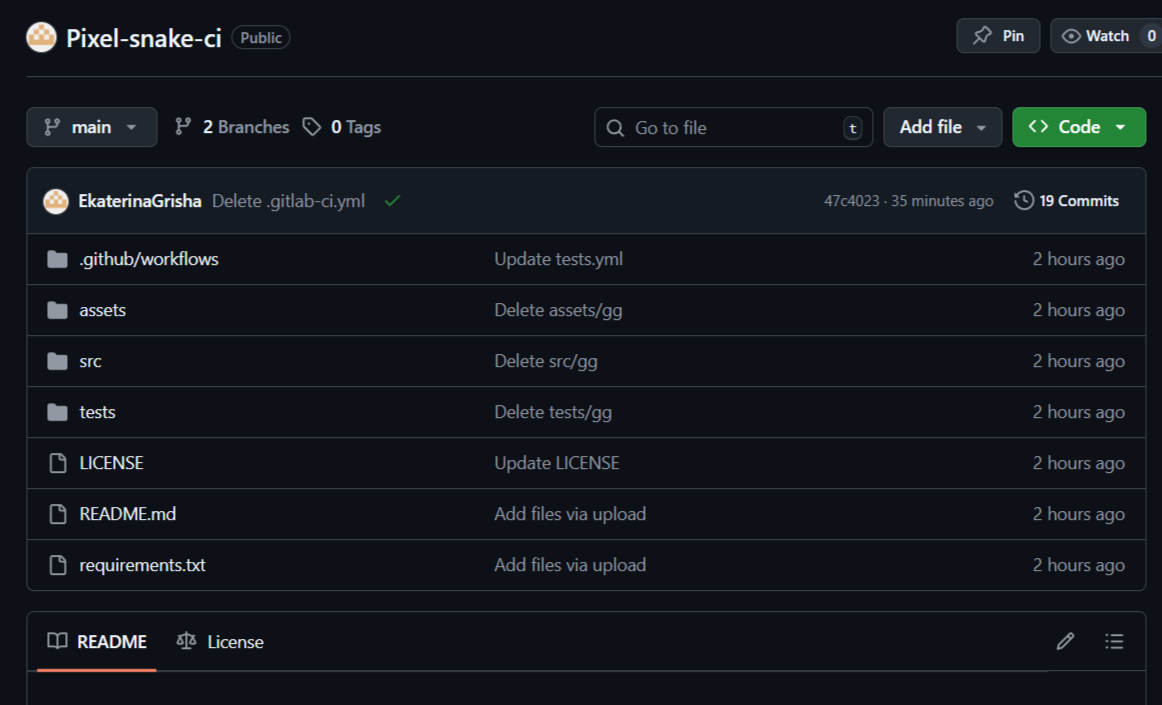

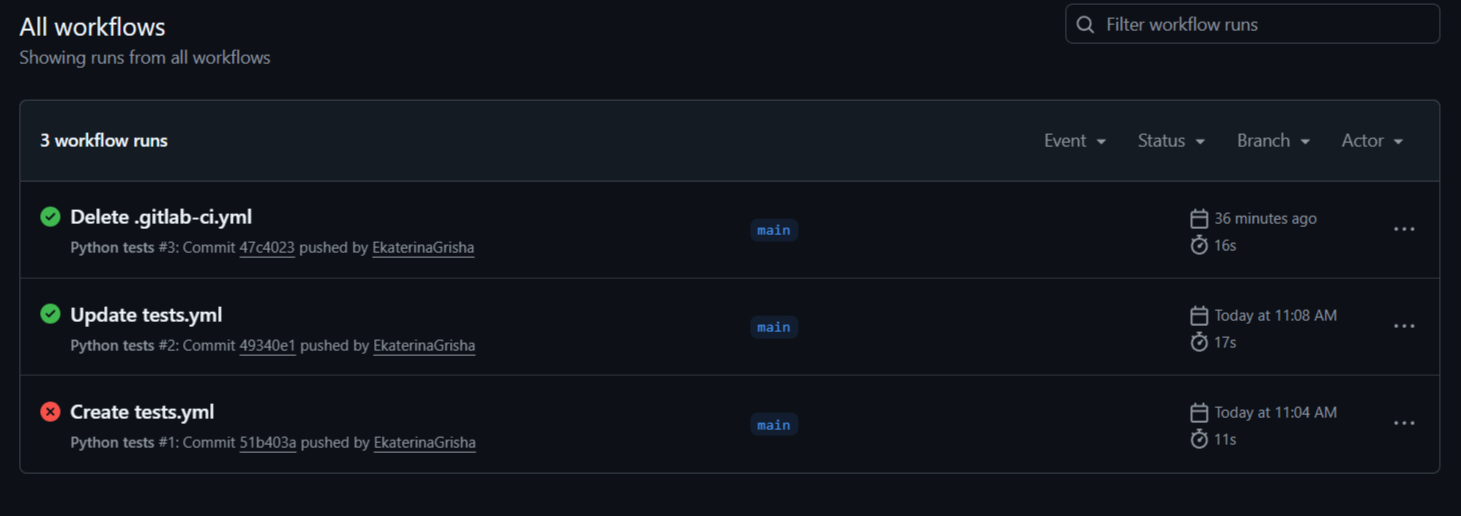

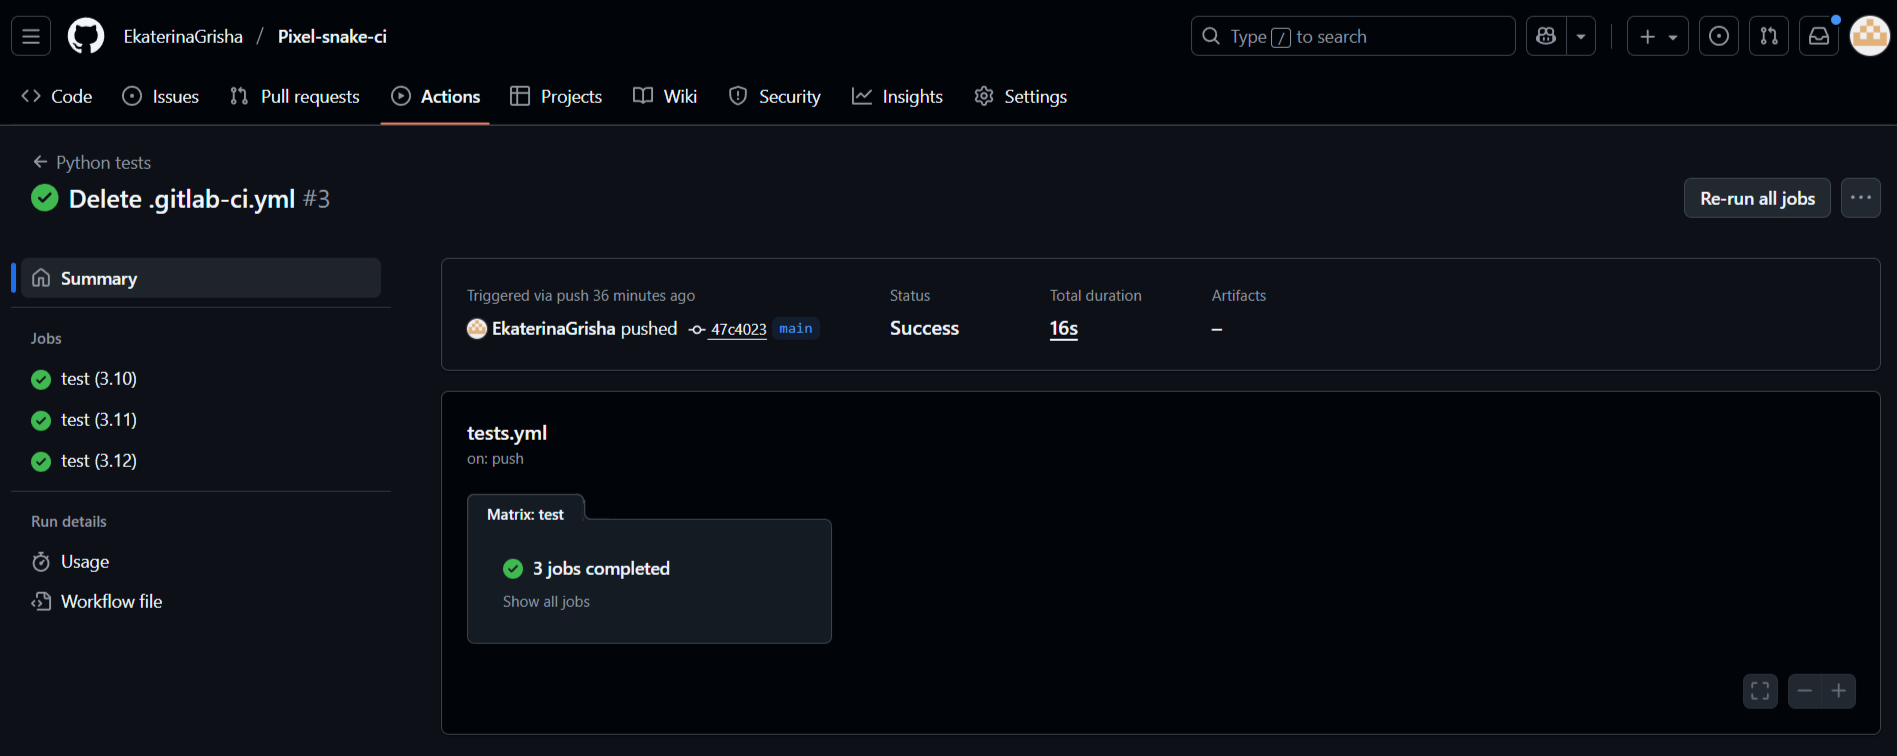
